# Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Dropout, Conv1D, Conv2D,
                                     MaxPooling2D, Input, GlobalAveragePooling2D, Rescaling)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19

# Config

In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

L2_REG_STRENGTH = 0.0001
FNN_EPOCHS = 100
CNN_EPOCHS = 50
BATCH_SIZE = 64
IMG_SIZE = (32, 32, 3)
NUM_CLASSES = 10

# Helper function

In [3]:
def plot_history(history, title, metric='accuracy', val_metric='val_accuracy'):
    acc = history.history[metric]
    val_acc = history.history[val_metric]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label=f'Training {metric}')
    plt.plot(epochs_range, val_acc, label=f'Validation {metric}')
    plt.legend(loc='lower right')
    plt.title(f'{title}: Training and Validation {metric}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title}: Training and Validation Loss')
    plt.show()

def plot_confusion_matrix_heatmap(model, x_test, y_test, class_names):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# FNN Regression

In [4]:
def prepare_housing_data():
    data = fetch_california_housing()
    X, y = data.data, data.target

    # Split: Train full (85%) / Test (15%)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)
    # Split Train full -> Train / Val
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=SEED)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return (X_train_scaled, y_train), (X_val_scaled, y_val), (X_test_scaled, y_test)

def build_fnn_regression(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Linear activation for regression
    ], name="FNN_Regression")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def run_fnn_experiment():
    print("\n" + "="*40)
    print("RUNNING PART 1: FNN REGRESSION")
    print("="*40)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_housing_data()

    model = build_fnn_regression(x_train.shape[1])
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        epochs=FNN_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        callbacks=[es],
        verbose=1
    )

    loss, mae = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nFNN Result - Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")
    plot_history(history, "FNN Regression", metric='mae', val_metric='val_mae')

# CNN Classification

In [5]:
def prepare_cifar_data():
    (x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

    x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=SEED)

    # Normalize
    x_train = x_train.astype('float32') / 255.0
    x_val = x_val.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot
    y_train = to_categorical(y_train, NUM_CLASSES)
    y_val = to_categorical(y_val, NUM_CLASSES)
    y_test = to_categorical(y_test, NUM_CLASSES)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def build_cnn_models():
    """Returns a dictionary of models to compare"""
    models = {}

    # 1. Simple CNN
    m_simple = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ], name="CNN_Simple")
    models['CNN_Simple'] = m_simple

    # 2. Optimized CNN (Dropout + L2)
    m_opt = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(L2_REG_STRENGTH)),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(L2_REG_STRENGTH)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name="CNN_Optimized")
    models['CNN_Optimized'] = m_opt

    return models

def run_cnn_experiment():
    print("\n" + "="*40)
    print("RUNNING PART 2: CNN CLASSIFICATION")
    print("="*40)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_cifar_data()
    models = build_cnn_models()

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

        history = model.fit(
            x_train, y_train,
            epochs=CNN_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(x_val, y_val),
            callbacks=[es],
            verbose=1
        )

        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        results[name] = {'acc': test_acc, 'model': model, 'history': history}
        print(f"{name} Test Accuracy: {test_acc:.4f}")

    # Plot Comparison
    plt.figure(figsize=(10, 6))
    for name, res in results.items():
        plt.plot(res['history'].history['val_accuracy'], label=name)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Confusion Matrix for Best Model
    best_name = max(results, key=lambda k: results[k]['acc'])
    print(f"\nBest Model: {best_name} (Acc: {results[best_name]['acc']:.4f})")
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    plot_confusion_matrix_heatmap(results[best_name]['model'], x_test, y_test, class_names)

# Expand Reseach

In [6]:
def run_transfer_learning():
    print("\n" + "="*40)
    print("RUNNING PART 3: VGG19 TRANSFER LEARNING")
    print("="*40)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_cifar_data()

    inputs = Input(shape=IMG_SIZE)
    # Rescaling for VGG19 (expects inputs roughly -1 to 1 or 0-255 centered)
    # Here using simple scaling, VGG usually likes 'caffe' preprocessing but this works for demo
    x = Rescaling(scale=255.0)(inputs) # Revert to 0-255
    x = tf.keras.applications.vgg19.preprocess_input(x) # Use VGG native preprocessing

    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False # Freeze

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs, name="VGG19_Transfer")

    # Phase 1: Train Head
    print("Phase 1: Training Classification Head...")
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    hist1 = model.fit(x_train, y_train, epochs=15, batch_size=BATCH_SIZE,
                      validation_data=(x_val, y_val), verbose=1)

    # Phase 2: Fine-tuning
    print("Phase 2: Fine-tuning backbone...")
    base_model.trainable = True
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    hist2 = model.fit(x_train, y_train, epochs=20, batch_size=BATCH_SIZE,
                      validation_data=(x_val, y_val), callbacks=[es], verbose=1)

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nVGG19 Transfer Learning Test Accuracy: {acc:.4f}")

    # Combine histories for plotting
    acc_total = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc_total = hist1.history['val_accuracy'] + hist2.history['val_accuracy']

    plt.figure(figsize=(10, 6))
    plt.plot(acc_total, label='Training Acc')
    plt.plot(val_acc_total, label='Validation Acc')
    plt.axvline(x=14, color='green', linestyle='--', label='Start Fine-tuning')
    plt.title('VGG19 Transfer Learning Performance')
    plt.legend()
    plt.show()

# Main Exe


RUNNING PART 1: FNN REGRESSION


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2.4647 - mae: 1.1719 - val_loss: 0.6136 - val_mae: 0.5682
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6274 - mae: 0.5677 - val_loss: 0.4655 - val_mae: 0.5023
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5096 - mae: 0.5105 - val_loss: 0.4290 - val_mae: 0.4928
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4588 - mae: 0.4861 - val_loss: 0.3920 - val_mae: 0.4562
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4375 - mae: 0.4714 - val_loss: 0.3867 - val_mae: 0.4549
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4188 - mae: 0.4598 - val_loss: 0.3723 - val_mae: 0.4315
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4039 - mae: 0.4526 - val_loss: 0.3598 - val_mae: 0.4351
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3937 - mae: 0.4477 - val_loss: 0.3515 - val_mae: 0.4286
Epoch 9/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

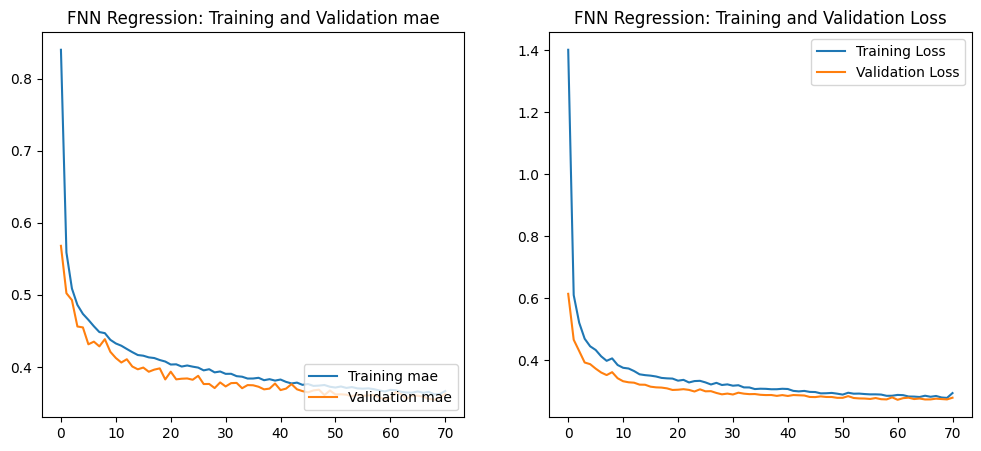


RUNNING PART 2: CNN CLASSIFICATION
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN_Simple...
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3107 - loss: 1.8457 - val_accuracy: 0.5190 - val_loss: 1.3282
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5278 - loss: 1.3188 - val_accuracy: 0.5785 - val_loss: 1.1802
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5962 - loss: 1.1502 - val_accuracy: 0.6084 - val_loss: 1.1062
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6405 - loss: 1.0355 - val_accuracy: 0.6177 - val_loss: 1.0921
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6646 - loss: 0.9561 - val_accuracy: 0.6352 - val_loss: 1.0502
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6883 - loss: 0.8929 - val_accuracy: 0.6383 - val_loss: 1.0545
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7069 - loss: 0.8386 - val_accuracy: 0.6485 - val_loss: 1.0244
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7252 - loss: 0

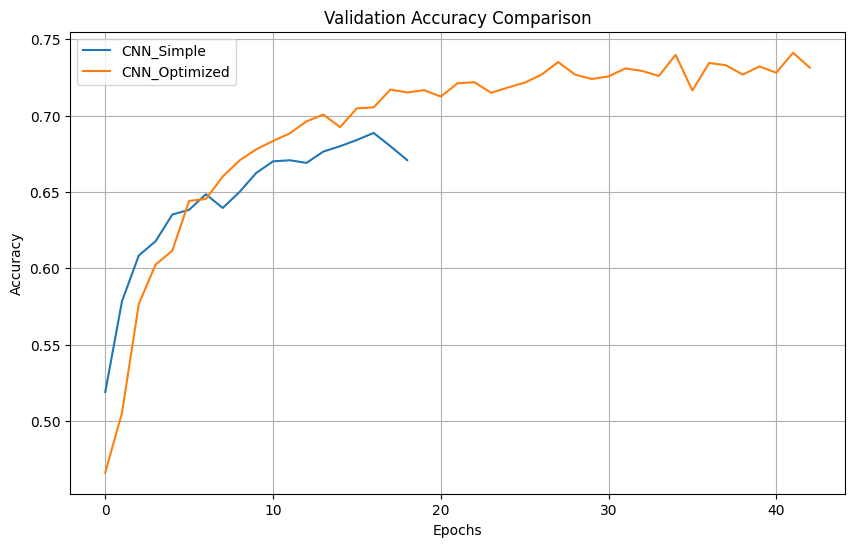


Best Model: CNN_Optimized (Acc: 0.7299)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


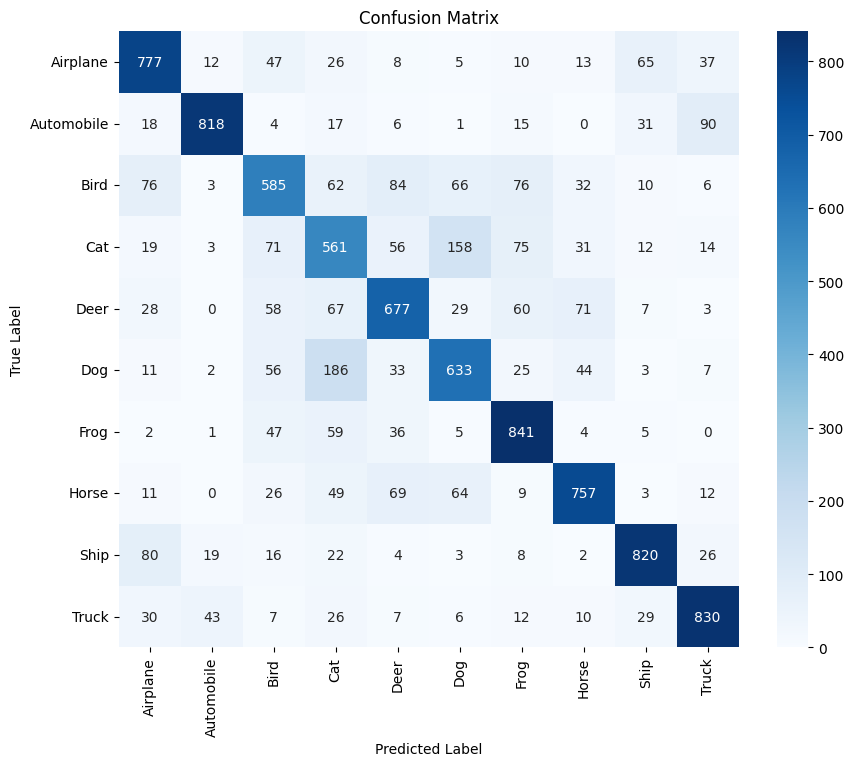


RUNNING PART 3: VGG19 TRANSFER LEARNING
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Phase 1: Training Classification Head...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.3043 - loss: 16.6548 - val_accuracy: 0.5771 - val_loss: 2.3447
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4877 - loss: 3.0411 - val_accuracy: 0.5660 - val_loss: 1.4950
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4859 - loss: 1.9797 - val_accuracy: 0.5671 - val_loss: 1.3888
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4808 - loss: 1.9222 - val_accuracy: 0.5600 - val_loss: 1.3967
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4833 - loss: 1.9115 - val_accuracy: 0.5559 - val_loss: 1.4114
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4842 - loss: 1.9288 - val_accuracy: 0.5600 - val_loss: 1.4040
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4829 - loss: 1.942

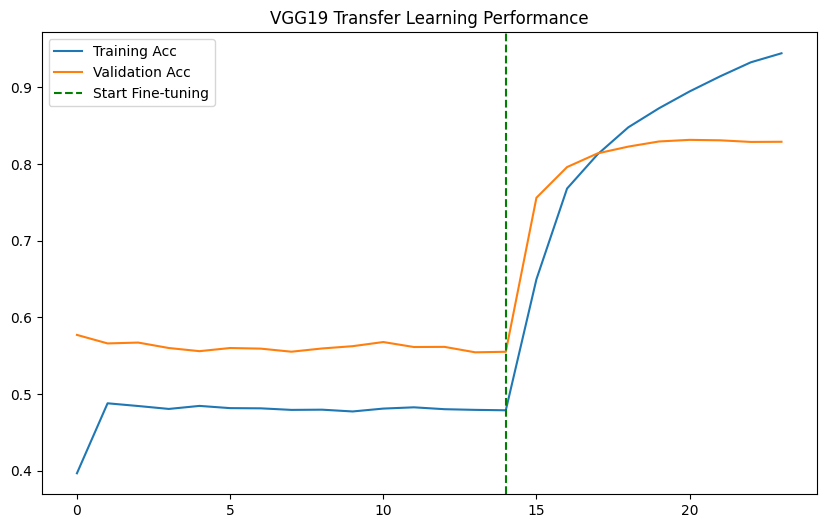

In [7]:
if __name__ == "__main__":
    # 1. Run FNN
    run_fnn_experiment()

    # 2. Run CNN
    run_cnn_experiment()

    # 3. Run Transfer Learning
    run_transfer_learning()